In [1]:
import numpy as np
import pandas as pd
import utils.data as data

location = '/data/petya/parquet/raw/'
# ipvdf, subset = data.getDataframes(location, 'ipv4')
ipvdf, subset = data.getDataframes(location, 'ipv6')

Success
/data/petya/parquet/raw/trace_ipv6 and /data/petya/parquet/raw//trace_ipv6_clean_paths exist.
Number of ipv6 tests: 3025431


In [2]:
%%time

# The code bellow takes complete paths as well as any complete parts of a path
# for example: if path is missing the 5th router of 12, the path will be split in 2
# and considered as sequnce1 - 1 to 4th router and sequece 2 - 6 to 12.
def extractCompleteSequences(ttls, hops):
    empty_positions = []
    consecutive_groups = []
    current_group = []
    consecutive_hops = []
    current_empty = []
    ttl2hop = {}
    
    if len(ttls) == len(hops):
        for i, num in enumerate(ttls):
            if i == 0 or num != ttls[i - 1] + 1:
                if len(current_group) > 1:
                    consecutive_groups.append(current_group)
                current_group = [num]
                
                if i>0: current_empty.append(i)
            else:
                current_group.append(num)
    
            ttl2hop[num] = hops[i]

        if len(current_empty)>0: empty_positions.append(current_empty)
        
        if len(current_group) > 1:
            consecutive_groups.append(current_group)


        for g in consecutive_groups:
            # print('--------', g)
            current_group = []
            for ip in g:
                current_group.append(ttl2hop[ip])

            consecutive_hops.append(current_group)
            # print(consecutive_hops)

    return consecutive_hops


# findMissingNumber returns the missing TTL values
def findMissingNumber(nums):    
    # Create a set of all the numbers from 1 to the largest number in the list.
    expected_numbers = set(range(1, nums[-1] + 1))
    
    # Find all the numbers that are missing from the TTL list.
    missing_numbers = expected_numbers - set(nums)
    
    # Return the missing numbers
    if len(missing_numbers) == 0:
        return None
    else:
        return (list(missing_numbers))


# extractSentences grabs all complete paths/sentences and
# the information about the missing IPs
def extractSentences(subset):
    sentences, missing1 = [], {}

    for i, row in subset[['hops', 'ttls', 'idx']].iterrows():
        hops, ttls, idx = row
        if len(ttls)>0:
            sentences.extend(extractCompleteSequences(ttls, hops))

            # keep the index for further reference and store missing TTLs
            mis = findMissingNumber(list(ttls))
            if mis:
                missing1[idx] = mis

    return sentences, missing1

# the sentences are the paths as lists of hops (IP addresses)
sentences, missing1 = extractSentences(subset)
print("Number of senteces: ", len(sentences))

Number of senteces:  359087
CPU times: user 10.4 s, sys: 124 ms, total: 10.6 s
Wall time: 10.6 s


In [3]:
%%time
# Create a vocabulary which consists of IP addresses mapped to IDs
def createVocabulary(sentences):
    word_to_idx = {}
    idx_to_word = {}
    for sentence in sentences:
        for word in sentence:
            if word not in word_to_idx:
                idx = len(word_to_idx)+1
                word_to_idx[word] = idx
                idx_to_word[idx] = word
    return word_to_idx, idx_to_word


word_to_idx, idx_to_word = createVocabulary(sentences)

print('Number of words:', len(word_to_idx))

# Convert sentences to sequences of indices
sequences = [[word_to_idx[word] for word in sentence] for sentence in sentences]

# Padding sequences for consistent input length
# max_sequence_length = max(len(sequence) for sequence in sequences)
# padded_sequences = [sequence + [-1] * (max_sequence_length - len(sequence)) for sequence in sequences]

Number of words: 2139
CPU times: user 663 ms, sys: 73.4 ms, total: 737 ms
Wall time: 732 ms


In [4]:
%%time
# Split the data into fixed lenght seuences
# The middle value is taken as a label 
# so that we can take into account previuos and next values
def splitSequence(sequnces, n_steps):
    X = []
    y = []
    for seq in sequnces:

        for i in range(len(seq)):

            if i < len(seq) - n_steps + 1:
                group = seq[i:i + n_steps]
                middle = group[2]
                group.pop(2)
                y.append(middle)
                X.append(group)

    # Convert X and y into numpy array
    X = np.array(X)
    y = np.array(y)
    
    return X,y 

n_steps = 5
X, y = splitSequence(sequences, n_steps = n_steps)
X.shape

CPU times: user 1.63 s, sys: 199 ms, total: 1.83 s
Wall time: 1.82 s


(1112912, 4)

In [5]:
# Due to the volum of created inputs in the previous step,
# we need to drop all identical X-y values
def remove_duplicate_sequences(X, y):
    unique_sequences = {}  # Dictionary to store unique sequences

    # Lists to store filtered X and y
    filtered_X = []
    filtered_y = []

    for i, sequence in enumerate(X):
        # Convert the sequence to a tuple to use it as a dictionary key
        sequence_tuple = tuple(sequence)

        # Check if the sequence_tuple is already in the dictionary
        if sequence_tuple not in unique_sequences:
            # If not seen before, add it to the dictionary and store X and y
            unique_sequences[sequence_tuple] = i
            filtered_X.append(sequence)
            filtered_y.append(y[i])

    return np.array(filtered_X), np.array(filtered_y)

# Example usage:
X, y = remove_duplicate_sequences(X, y)
X.shape

(19292, 4)

### Build the model

In [6]:
%%time
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torch.utils.data.dataset import random_split

# Define the GRU model
class GRUModel(nn.Module):
    def __init__(self, total_words, embedding_dim, hidden_size, num_classes):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(total_words, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)
        gru_out, _ = self.gru(embedded)
        output = self.fc(gru_out[:, -1, :])  # Pass it through the linear layer
        return output



# Check if CUDA is available and get the number of available GPUs
# The model is simple, yet with the current configuration it requeres 3-4GB GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()
else:
    num_gpus = 0

X = torch.tensor(X, dtype=torch.long).to(device)
total_words = len(word_to_idx) + 1

# not all words are classes. Take only the ones in Y 
num_classes = len(set(y))+2

# reindex the labels, since it takes too much resources if we take all possible words
y2idx = {y:idx+1 for idx, y in enumerate(set(y))}
y_reindexed = [y2idx[y] for y in y]
y_onehot = torch.nn.functional.one_hot(torch.tensor(y_reindexed), num_classes=len(set(y))+2).long().to(device)




hidden_size = 150
embedding_dim = 250 
learning_rate = 0.01

# Instantiate the model
model = GRUModel(total_words, embedding_dim, hidden_size, num_classes)
print(model)

# Move the model to the GPU(s)
if num_gpus > 1:
    model = nn.DataParallel(model, device_ids=[0, 1])
model = model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss for classification tasks
optimizer = optim.Adam(model.parameters(), lr=learning_rate)



# Define the split ratios (e.g., 80% for training, 20% for validation)
train_ratio = 0.8
val_ratio = 1 - train_ratio

# Create the dataset
dataset = TensorDataset(X, y_onehot)

# Calculate the sizes of the splits
train_size = int(len(dataset) * train_ratio)
val_size = len(dataset) - train_size

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 5000
# Create DataLoader for training and validation
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

GRUModel(
  (embedding): Embedding(2140, 250)
  (gru): GRU(250, 150, batch_first=True)
  (fc): Linear(in_features=150, out_features=1421, bias=True)
)
CPU times: user 4.81 s, sys: 1.42 s, total: 6.23 s
Wall time: 22.7 s


### Train the model

Epoch [1/100], Loss: 26.1772, Validation Loss: 4.9789
Epoch [2/100], Loss: 17.3582, Validation Loss: 3.3029
Epoch [3/100], Loss: 11.6165, Validation Loss: 2.2411
Epoch [4/100], Loss: 8.0913, Validation Loss: 1.5521
Epoch [5/100], Loss: 5.8236, Validation Loss: 1.1659
Epoch [6/100], Loss: 4.3385, Validation Loss: 0.8770
Epoch [7/100], Loss: 3.3495, Validation Loss: 0.6835
Epoch [8/100], Loss: 2.8050, Validation Loss: 0.6454
Epoch [9/100], Loss: 2.4341, Validation Loss: 0.5288
Epoch [10/100], Loss: 2.2114, Validation Loss: 0.4501
Epoch [11/100], Loss: 2.0568, Validation Loss: 0.4598
Epoch [12/100], Loss: 1.9585, Validation Loss: 0.4076
Epoch [13/100], Loss: 1.8058, Validation Loss: 0.4663
Epoch [14/100], Loss: 1.8089, Validation Loss: 0.4505
Epoch [15/100], Loss: 1.7138, Validation Loss: 0.4811
Epoch [16/100], Loss: 1.5732, Validation Loss: 0.3633
Epoch [17/100], Loss: 1.5284, Validation Loss: 0.4156
Epoch [18/100], Loss: 1.4748, Validation Loss: 0.3924
Epoch [19/100], Loss: 1.4172, Vali

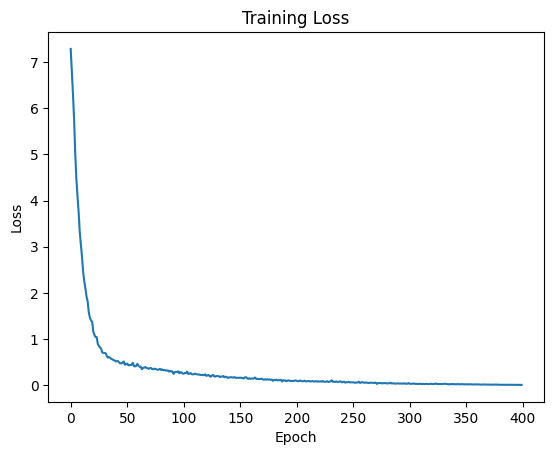

In [7]:
num_epochs = 100
best_val_loss = float('inf')  # Initialize with a large value
patience = 20  # Number of epochs to wait before early stopping

# this is to convert back to the labels ids
idx2y = {idx:y for y, idx in y2idx.items()}


losses = []
for epoch in range(num_epochs):
    total_loss = 0
    for batch_inputs, batch_targets in train_dataloader:
        optimizer.zero_grad()
        outputs = model(batch_inputs)
        # print(batch_inputs.shape, batch_targets.shape, outputs.shape)
        
        loss = criterion(outputs, batch_targets.argmax(dim=1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        losses.append(loss.item())
    # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}')

    # Calculate validation loss
    with torch.no_grad():
        for X_val, y_val in train_dataloader:
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val.argmax(dim=1))
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}, Validation Loss: {val_loss:.4f}')
        
        # # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break


# Plot the loss
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

#### Clear GPU cache in case it's neccessary

In [12]:
# import gc
# import torch


# n = gc.collect()
# print("Number of unreachable objects collected by GC:", n)
# torch.cuda.empty_cache()

# allocated_memory = torch.cuda.memory_allocated()

# # Check the current GPU memory cached by PyTorch
# cached_memory = torch.cuda.memory_cached()

# # Print the results
# print(f"Allocated Memory: {allocated_memory / 1024**2} MB")
# print(f"Cached Memory: {cached_memory / 1024**2} MB")

#### Take the incomplete paths and prepare them for prediction

In [9]:
%%time
# Search for incomplete paths which values can be predicted
def extractSequnces4Prediction(missing1, subset):
    moreThan1Cnt = 0
    seq4pred = {}
    dfidx2missingTTL = {}
    for i, vals in missing1.items():

        if len(vals)==1:
            
            ttls = subset.loc[subset['idx'] == i]['ttls'].values[0]
            hops = subset.loc[subset['idx'] == i]['hops'].values[0]

            idx = [n for n,c in enumerate(ttls) if c in [vals[0]-2, vals[0]-1, vals[0]+1, vals[0]+2] ]
            ips = hops[min(idx):max(idx)+1]

            # take only those sequences which have a full set of values - 4
            if len(ips)==4:
                test_sequence = [word_to_idx[word] for word in ips]
                seq4pred[i] = test_sequence
                # stores the index of the test in the datataframe along with the missing ttl value
                dfidx2missingTTL[i] = idx[2]

        else: 
            moreThan1Cnt+=1

    
    # TODO: Look at those missing more than 1 value and try to repair as well
    print("Number of tests missing >1 values:", moreThan1Cnt)
    return seq4pred, dfidx2missingTTL

seq4pred, df_Idx2missing_TTL = extractSequnces4Prediction(missing1, subset)
print("Number of paths, good candidates for repair (missing a sinlge router in the middle of a path) ", len(seq4pred))


Number of tests missing >1 values: 119705
Number of paths, good candidates for repair (missing a sinlge router in the middle of a path)  28577
CPU times: user 27.4 s, sys: 457 ms, total: 27.9 s
Wall time: 27.9 s


#### Use the model and repair missing IPs where feasible

In [10]:
import hashlib


# Inference
def predicValue(sequence):
    test_input = torch.tensor([sequence], device='cuda:0')
    # print(test_input)
    with torch.no_grad():
        model.eval()
        predicted_logits = model(test_input)
        predicted_class = torch.argmax(predicted_logits, dim=1)
    
    # print("Predicted Class:", predicted_class.item())
    return predicted_class.item()


ipvdf['dt'] = pd.to_datetime(ipvdf['timestamp'], unit='ms')
repair = ipvdf[ipvdf['idx'].isin(missing1)][['dt', 'src', 'hops', 'route', 'ttls', 'rtts', 'site_pair', 'ipv6', 'destination_reached']].copy()
idx2y = {idx:y for y, idx in y2idx.items()}

repair['up_sha1'] = ''
repair['up_hops'] = ''


# This is bad code. The loop should be over df_Idx2missing_TTL. FIXME!
for idx, row in repair[['hops', 'route','destination_reached']].iterrows():
    # 
    r, sha, destination_reached = row
    if destination_reached: r= r[:-1]
    # if not dr:
    if idx in df_Idx2missing_TTL: 
        # print(idx)
        new_hops = list(r).copy()
        
        i2insert_the_new = df_Idx2missing_TTL[idx]
        missing_id = predicValue(seq4pred[idx])
        predicted = idx_to_word[idx2y[missing_id]]
        new_hops.insert(i2insert_the_new, predicted)
        
        # print(len(new_hops), len(r))
        # print()
        route_hash = hashlib.sha1()
        route_hash.update(";".join(new_hops).encode())
        # print(route_hash.hexdigest(), sha)
        repair.loc[repair.index==idx, 'up_sha1'] = route_hash.hexdigest()
        repair.loc[repair.index==idx, 'up_hops'] = str(new_hops)
    else:
        repair.loc[repair.index==idx, 'up_sha1'] = sha


len(subset['route'].unique()), len(repair['up_sha1'].unique())

(111891, 95878)

### Examples

In [11]:
for idx, row in repair[repair['up_hops']!=''][['hops', 'up_hops', 'ttls', 'up_sha1', 'route', 'site_pair']].sample(5).iterrows():
    old_route, new_route, ttls, newsha, oldsha, sites = row
    print('TTLs:', ttls)
    
    new_hops = list(old_route).copy()   
    i2insert_the_new = df_Idx2missing_TTL[idx]
    missing_id = predicValue(seq4pred[idx])
    predicted = idx_to_word[idx2y[missing_id]]

    new_hops.insert(i2insert_the_new, '*******')
    print('Incomplete path:', new_hops)
    
    print('Predicted value:', predicted)
    print('route-sha1:', oldsha)
    print('Sites:', sites)
    print()

TTLs: [ 1  2  3  4  5  6  7  8  9 10 12 13 14 15 16 17]
Incomplete path: ['2605:9a00:10:200a::2', '2605:9a00:10:1::1', '2605:9a00:10:1::4', '2001:468:2a00::4', '2001:468:0:1::114', '2001:468:0:1::117', '2001:468:0:1::5c', '2001:468:0:1::11f', '2001:468:0:1::fc', '2001:468:0:1::104', '*******', '2001:1348:4:3::1', '2001:1348::1e', '2001:1348::14', '2001:1348:1:7::5', '2001:1310:7211:132a::2', '2001:1310:7211:132a::2']
Predicted value: 2001:468:0:1::121
route-sha1: b7ef4bab850ca91404489d77a5f8e89a6019fe83
Sites: MWT2 -> EELA-UTFSM

TTLs: [ 1  2  3  4  5  6  7  8  9 10 12 13 14 15 16]
Incomplete path: ['2a05:81c5:302:224::1', '2a05:81c5:4:8::139', '2a05:81c5:4:8::138', '2001:67c:1bec::a:151', '2001:67c:1bec::a:150', '2001:798:99:1::8e', '2001:798:99:1::8d', '2001:798:cc::1a', '2001:798:cc::39', '2001:798:2b:10aa::2', '*******', '2001:b30:0:ab::2', '2001:b30:0:a1::2', '2001:b30:0:1106::2', '2001:b30:1000:10::10', '2001:b30:1002:612::1119']
Predicted value: 2001:b30:0:aa::1
route-sha1: ccc8